# Assignment 2 - Spark Dataframes
***Note***: All the dataset files were stored in the same folder as this notebook.

<a id='toc'></a>
## Table of Contents:
- <a href='#d'>Dependencies</a>
- <a href='#i'>Instructions on running the code</a>
- <a href='#sc'>Start a Spark Session</a>
- <a href='#q1'>Question 1</a>
- <a href='#q2'>Question 2</a>
- <a href='#q3'>Question 3</a>
- <a href='#q4'>Question 4</a>
- <a href='#q5'>Question 5</a>
- <a href='#q6'>Question 6</a>
- <a href='#q7'>Question 7</a>

<a id='d'></a>
## Dependencies

### JDK 8

Download link: https://www.oracle.com/java/technologies/javase/javase8-archive-downloads.html

You will need to create an account and sign-in in order to download it.

Press start and search for "Edit environment variables for your account"

Click new and add 'JAVA_HOME' with the path for your java jdk folder e.g. C:\Program Files\Java\jdk1.8.0_202 and add 'JRE_HOME' with the path for your java jre folder e.g. C:\Program Files\Java\jre1.8.0_361

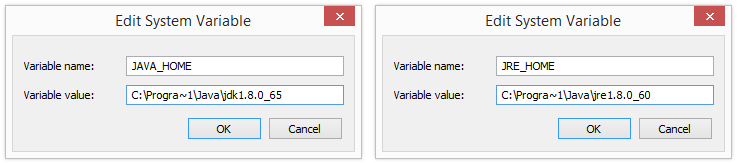

### PySpark
PySpark installation using PyPI is as follows:
```python
pip install pyspark
pip install pyarrow
```
If you want to install extra dependencies for a specific component, you can install it as below:
```bash
# Spark SQL
pip install pyspark[sql]
# pandas API on Spark
pip install pyspark[pandas_on_spark] plotly  # to plot your data, you can install plotly together
```
More info about about installing PySpark: [PySpark Installation Guide](https://spark.apache.org/docs/latest/api/python/getting_started/install.html#using-pypi)

### Haversine
```
pip install haversine
```

More info about about Haversine: https://pypi.org/project/haversine/

<a id='i'></a>
## Intstructions on running the code:
After you <a href='#sc'>start a spark session</a>, you can run each cell in the notebook independently.

<a id='sc'></a>

## Start a Spark Session
<a href='#toc'>Table of Contents</a>

In [1]:
import os
import pyspark
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
conf = pyspark.SparkConf()
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)
spark

<a id='q1'></a>

## 1. 15 Points
**Datafile**: BreadBasket_DMS.csv

**Solve**: What is the most popular (most sold) between the 8:00AM and 8:59AM for each day?

Example output (not actual solution)

    2016-10-30, Pastry

    2016-10-31, Coffee
     :
     :

### Approach:
1. Import BreadBasket_DMS.csv into a dataframe and filter out rows with `NONE` in the `Item` column
2. Extract dates in `YYYY-MM-DD` format from the `Date` column and times in `hh:mm:ss` format from the `Time` column
3. Filter the data by `Time` in the range of `08:00:00` and `08:59:00` inclusive
4. Group the data by `Date` and `Item`, aggregate by the `count` and, sort by `Date` and `count`
5. Group the data by `Date` and return the `last` `Item` and `last` `count`

<a href='#toc'>Table of Contents</a>

In [2]:
# 1. Import BreadBasket_DMS.csv into a dataframe and filter out rows with `NONE` in the `Item` column
from pyspark.sql.functions import col
BreadBasket_DMS = spark.read.option("header", True).option("InferSchema", True).csv("BreadBasket_DMS.csv")
BreadBasket_DMS = BreadBasket_DMS.filter(col("Item") != "NONE")

# 2. Extract dates in `YYYY-MM-DD` format from the `Date` column and times in `hh:mm:ss` format from the `Time` column
from pyspark.sql.functions import to_date, date_format
BreadBasket_DMS = BreadBasket_DMS.withColumn("Date", to_date(col("Date"), "YYYY-MM-DD"))
BreadBasket_DMS = BreadBasket_DMS.withColumn("Time", date_format(col("Time"),"hh:mm:ss"))

# 3. Filter the data by `Time` in the range of `08:00:00` and `08:59:00` inclusive 
q1 = BreadBasket_DMS
q1 = q1.filter((col("Time") <= "08:59:00") & (col("Time") >= "08:00:00"))

# 4. Group the data by `Date` and `Item`, aggregate by the `count` and, sort by `Date` and `count`
q1 = q1.groupBy("Date","Item").count().sort("Date","count")

# 5. Group the data by `Date` and return the last `Item` and last `count`
from pyspark.sql.functions import last
q1 = q1.groupBy("Date").agg(last("Item").alias("Most Popular Iteam"),last("count").alias("Total Transactions"))

# Display results
print("1. List of the most popular (most sold) items between the 8:00 AM and 8:59 AM for each day and their total transactions that day:")
q1.show()

1. List of the most popular (most sold) items between the 8:00 AM and 8:59 AM for each day and their total transactions that day:
+----------+------------------+------------------+
|      Date|Most Popular Iteam|Total Transactions|
+----------+------------------+------------------+
|2016-10-31|             Bread|                 2|
|2016-11-01|               Tea|                 3|
|2016-11-02|            Coffee|                 8|
|2016-11-03|            Coffee|                 4|
|2016-11-04|            Coffee|                 2|
|2016-11-05|             Bread|                 6|
|2016-11-07|            Coffee|                 1|
|2016-11-08|            Coffee|                 1|
|2016-11-09|            Coffee|                 1|
|2016-11-10|            Coffee|                 2|
|2016-11-11|             Bread|                 6|
|2016-11-12|         Medialuna|                 1|
|2016-11-14|            Coffee|                 2|
|2016-11-15|  Keeping It Local|                 1|
|20

<a id='q2'></a>

## 2. 15 Points
**Datafile**: BreadBasket_DMS.csv

**Solve**: What is the most common item bought along with “Brownie”? (items bought in the same transaction)

### Assumptions:
We will assume that we will count each time an item was bought with “Brownie”. If an item was bought more than once in the same transaction we will count each time that item was bought in that transaction.

### Approach:
1. Import BreadBasket_DMS.csv into a dataframe and filter out rows with `NONE` in the `Item` column
2. Extract dates in `YYYY-MM-DD` format from the `Date` column and times in `hh:mm:ss` format from the `Time` column
3. Create 2 lists of transactions: one with and one without “Brownie” in the `Item` column by using `filter()`
4. Use a `left_semi` join where the `Transaction` is the same only keeping items bought with “Brownie”
5. Group the data by `Item`, aggregate by `count()` of the data and, sort the data by `count` in descending order

<a href='#toc'>Table of Contents</a>

In [3]:
# 1. Import BreadBasket_DMS.csv into a dataframe and filter out rows with `NONE` in the `Item` column
from pyspark.sql.functions import col
BreadBasket_DMS = spark.read.option("header", True).option("InferSchema", True).csv("BreadBasket_DMS.csv")
BreadBasket_DMS = BreadBasket_DMS.filter(col("Item") != "NONE")

# 2. Extract dates in `YYYY-MM-DD` format from the `Date` column and times in `hh:mm:ss` format from the `Time` column
from pyspark.sql.functions import to_date, date_format
BreadBasket_DMS = BreadBasket_DMS.withColumn("Date", to_date(col("Date"), "YYYY-MM-DD"))
BreadBasket_DMS = BreadBasket_DMS.withColumn("Time", date_format(col("Time"),"hh:mm:ss"))

# 3. Create 2 lists of transactions: one with and one without “Brownie” in the `Item` column by using `filter()`
BrownieTransactions = BreadBasket_DMS.filter(col("Item") == "Brownie").sort("Transaction")
OtherTransactions = BreadBasket_DMS.filter(col("Item") != "Brownie")

# 4. Use a `left_semi` join where the `Transaction` is the same only keeping items bought with “Brownie”
JoinExpression = BrownieTransactions["Transaction"] == OtherTransactions["Transaction"]
ItemBougtWithBrownie = OtherTransactions.join(BrownieTransactions,JoinExpression, "left_semi").sort("Transaction")

# 5. Group the data by `Item`, aggregate by `count()` of the data and, sort the data by `count` in descending order
from pyspark.sql.functions import desc
ItemBougtWithBrownie = ItemBougtWithBrownie.groupBy("Item").count().sort(desc("count"))

# Display results
ItemBougtWithBrownie.persist()
print(f"2. The common items bought with along with “Brownie” is “{ItemBougtWithBrownie.first()[0]}“ which was purchased {ItemBougtWithBrownie.first()[1]} times")
print("    List of the most common items bought along with “Brownie” sorted by their counts:")
ItemBougtWithBrownie.show()

2. The common items bought with along with “Brownie” is “Coffee“ which was purchased 237 times
    List of the most common items bought along with “Brownie” sorted by their counts:
+-----------------+-----+
|             Item|count|
+-----------------+-----+
|           Coffee|  237|
|            Bread|  115|
|              Tea|   71|
|             Cake|   43|
|    Hot chocolate|   42|
|        Alfajores|   27|
|         Sandwich|   27|
|          Cookies|   26|
|            Juice|   24|
|           Pastry|   23|
|        Medialuna|   19|
|           Muffin|   18|
|             Soup|   15|
|            Scone|   12|
|       Farm House|   11|
|             Coke|   11|
|         Truffles|   11|
|    Mineral water|    9|
|            Toast|    7|
|Hearty & Seasonal|    6|
+-----------------+-----+
only showing top 20 rows



<a id='q3'></a>

## 3. 10 Points
**Datafile**: Restaurants_in_Durham_County_NC.csv

__NOTE*** This file is colon delimited (not comma) ***__

**Solve**: How many years are represented in this dataset?

Inspecting the Restaurants_in_Durham_County_NC.csv file, I noticed that there several line breaks in the file that cause PySpark to think that this is a new row. Here is an example of this:

<table>
  <tr>
    <td>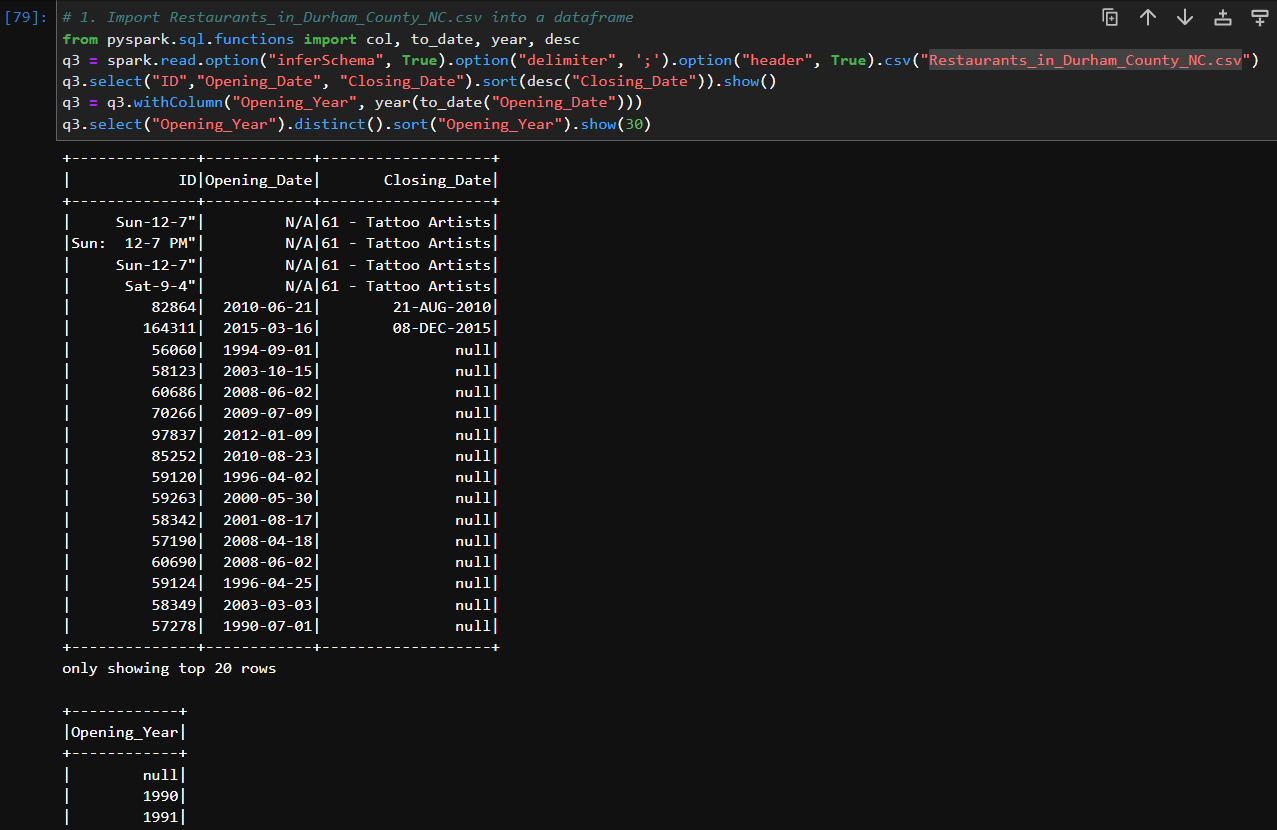</td>
    <td>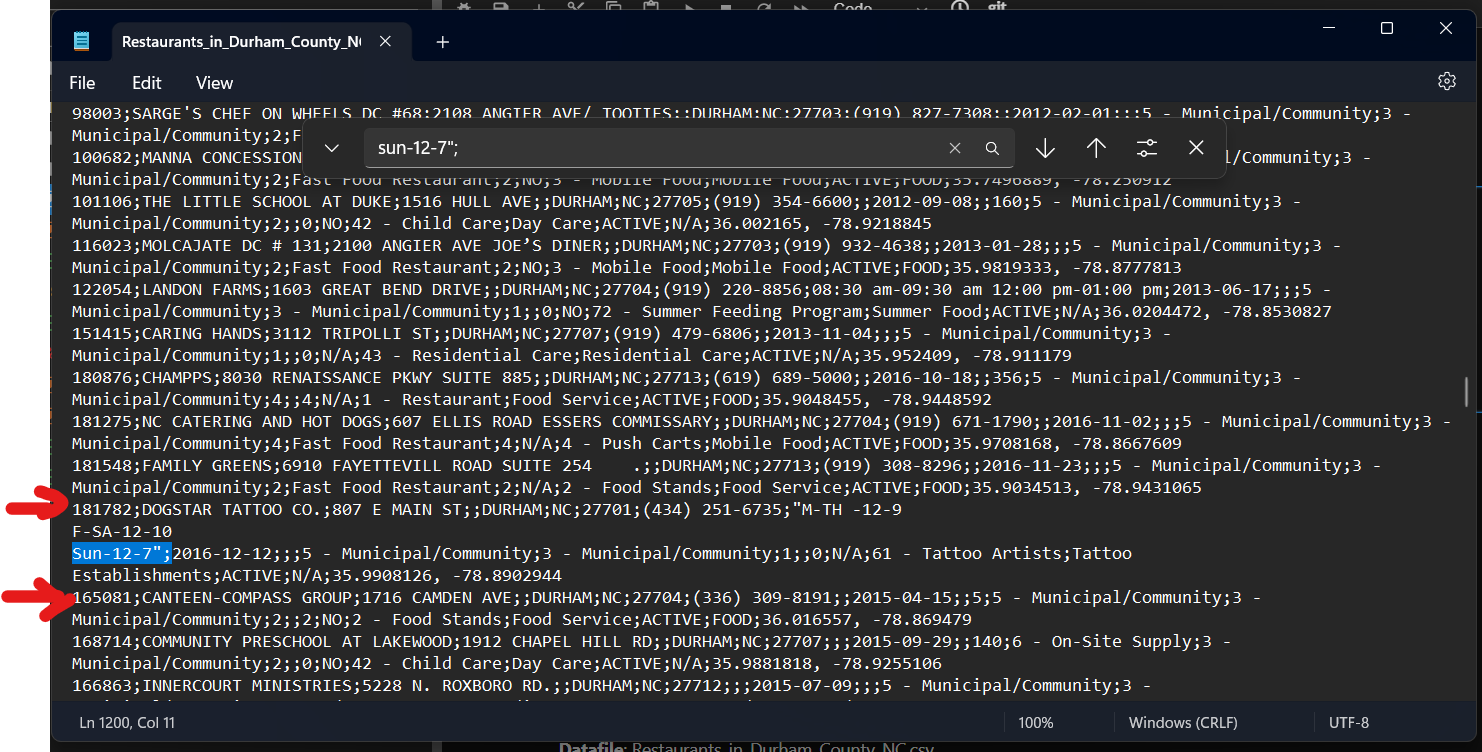</td>
  </tr>
</table>

To fix this, I used `.option("multiline",True)`

Source: https://stackoverflow.com/questions/48800046/escape-new-line-character-in-spark-csv-read

### Approach:
1. Import `Restaurants_in_Durham_County_NC` into a dataframe
2. Extract the year in "yyyy" format from the `Opening_Date` column into a new `Opening_Year` column
3. Select the `Opening_Year` column, keep only unique items and, sort by `Opening_Year`
4. Display the result. Extracting single value from DataFrame: https://www.geeksforgeeks.org/pyspark-extracting-single-value-from-dataframe/

<a href='#toc'>Table of Contents</a>

In [4]:
# 1. Import Restaurants_in_Durham_County_NC.csv into a dataframe
# Source for reading csv files with multiline: https://stackoverflow.com/questions/48800046/escape-new-line-character-in-spark-csv-read
Restaurants = spark.read\
.option("inferSchema", True)\
.option("delimiter", ';')\
.option("header", True)\
.option("multiline", True)\
.csv("Restaurants_in_Durham_County_NC.csv")

# 2. Extract the year in "yyyy" format from the `Opening_Date` column into a new `Opening_Year` column
from pyspark.sql.functions import col, to_date, year
Restaurants = Restaurants.withColumn("Opening_Year", year(to_date("Opening_Date")))

# 3. Select the `Opening_Year` column, keep only unique items and, sort by `Opening_Year`
Years = Restaurants.select("Opening_Year").distinct().sort("Opening_Year")

# 4. Display the results
# Extracting single value from DataFrame: https://www.geeksforgeeks.org/pyspark-extracting-single-value-from-dataframe/
from pyspark.sql.functions import first, last
Years.persist()
print(f"3. There are {Years.count()} years are represented in this dataset. They span from {Years.first()[0]} to {Years.tail(1)[0][0]}")
Years.show(Years.count())

3. There are 28 years are represented in this dataset. They span from 1990 to 2017
+------------+
|Opening_Year|
+------------+
|        1990|
|        1991|
|        1992|
|        1993|
|        1994|
|        1995|
|        1996|
|        1997|
|        1998|
|        1999|
|        2000|
|        2001|
|        2002|
|        2003|
|        2004|
|        2005|
|        2006|
|        2007|
|        2008|
|        2009|
|        2010|
|        2011|
|        2012|
|        2013|
|        2014|
|        2015|
|        2016|
|        2017|
+------------+



<a id='q4'></a>

## 4. 20 Points
**Dataset**: Restaurants_in_Durham_County_NC.csv

**Solve**: Show the type and count of restaurant opened during the 90’s (1990-1999 inclusive). Note: type=”Rpt_Area_Desc”

Example (not the actual result):
  
    “Swimming Pools”,  13
  
    “Tatoo Establishment”,  2
  
     :
### Approach:
1. Import Restaurants_in_Durham_County_NC.csv into a dataframe
2. Extract the year in "yyyy" format from the `Opening_Date` column into a new `Opening_Year` column
3. Filter the `Opening_Year` column betwen 1990 and 1999 inclusive
4. Group by the column `Rpt_Area_Desc` and aggregate by `count`

<a href='#toc'>Table of Contents</a>

In [5]:
from pyspark.sql.functions import col, to_date, year
# 1. Import Restaurants_in_Durham_County_NC.csv into a dataframe
# Source for reading csv files with multiline: https://stackoverflow.com/questions/48800046/escape-new-line-character-in-spark-csv-read
Restaurants = spark.read\
.option("inferSchema", True)\
.option("delimiter", ';')\
.option("header", True)\
.option("multiline", True)\
.csv("Restaurants_in_Durham_County_NC.csv")

# 2. Extract the year in "yyyy" format from the `Opening_Date` column into a new `Opening_Year` column
from pyspark.sql.functions import col, to_date, year
Restaurants = Restaurants.withColumn("Opening_Year", year(to_date("Opening_Date")))

# 3. Filter the `Opening_Year` column betwen 1990 and 1999 inclusive 
q4 = Restaurants.filter((col("Opening_Year") <= 1999) & (col("Opening_Year") >= 1990))
q4.persist()

# 4. Group by the column `Rpt_Area_Desc` and aggregate by `count`
q4 = q4.groupBy("Rpt_Area_Desc").count()

# Display the results
print("4. List of the type and count of restaurants opened during the 90’s (1990-1999 inclusive):")
q4.show()

4. List of the type and count of restaurants opened during the 90’s (1990-1999 inclusive):
+------------------+-----+
|     Rpt_Area_Desc|count|
+------------------+-----+
|Bed&Breakfast Home|    3|
|      Summer Camps|    1|
|      Institutions|   16|
| Local Confinement|    2|
|  School Buildings|   56|
|    Swimming Pools|  256|
|          Day Care|   58|
| Bed&Breakfast Inn|    1|
|           Lodging|   21|
|      Food Service|  204|
+------------------+-----+



<a id='q5'></a>

## 5. 25 Points
**Dataset**:  populationbycountry19802010millions.csv

**Solve**: For region, compute the ***percentage change*** in population, year over year.  Note the year 1980 will not have a preceding year. For each year, display the region with the top population ***decrease***.

**Example** (not actual results):

1981,  North America, -2%

1982, Aruba, -7%…

### Assumptions:
The region with the top population ***decrease*** has the lowest ***percentage change***.

### Approach:
1. Import populationbycountry19802010millions.csv in to a dataframe and rename `_c0` to `country`
2. Initialize an empty array called `q5_rows` to store the rows for the result
3. Loop through all the years
4. Find `Percentage Change` and sort by sort it in ascending order of `Percentage Change`
5. Add a `Year` column and store the year corresponding to the change
6. Append the first row which is the top population decrease or the lowest percentage change into `q5_rows`
7. Create a schema for a dataframe and store the rows from `q5_rows`

<a href='#toc'>Table of Contents</a>

In [6]:
# 1. Import populationbycountry19802010millions.csv in to a dataframe and rename `_c0` to `country`
population = spark.read.option("header", True).option("InferSchema", True).csv("populationbycountry19802010millions.csv")
population = population.withColumnRenamed("_c0", "country")

# 2. Initialize an empty array called `q5_rows` to store the rows for the result
q5_rows = []

# 3. Loop through all the years
from pyspark.sql.functions import col, first, lit
for year in range (1980, 2010):
    # 4. Find `Percentage Change` and sort by sort it in ascending order of `Percentage Change`
    _q5 = population.withColumn("PercChng", (col(str(year+1)) - col(str(year)))*100/col(str(year))).dropna().sort("PercChng")
    # 5. Add a `Year` column and store the year corresponding to the change
    _q5 = _q5.withColumn("Year", lit(year+1))
    # 6. Append the first row which is the top population decrease or the lowest percentage change into `q5_rows`
    q5_rows.append(_q5.select("Year", "Country", col("PercChng").alias("Percentage Change")).first())

# 7. Create a schema for a dataframe and store the rows from `q5_rows`
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DoubleType
q5_schema = StructType([
    StructField("Year", IntegerType(), True),
    StructField("Country", StringType(), True),
    StructField("Percentage Change", DoubleType(), True)])
q5 = spark.createDataFrame(q5_rows,q5_schema)

# Display the results
print("5. List of the regions with the top population decrease for 1980 to 2010:")
q5.show(30)

5. List of the regions with the top population decrease for 1980 to 2010:
+----+--------------------+-------------------+
|Year|             Country|  Percentage Change|
+----+--------------------+-------------------+
|1981|         Afghanistan| -9.106330931425992|
|1982|         Afghanistan| -8.017227257036874|
|1983| Antigua and Barbuda|-3.5141890898397343|
|1984| Antigua and Barbuda|-1.7525144772935055|
|1985|        Cook Islands|-1.4092446448703508|
|1986|Netherlands Antilles| -24.58781655279631|
|1987|        Saint Helena|-21.299638989169676|
|1988|          Mozambique| -2.883631837516533|
|1989|             Somalia|-2.1964965331028314|
|1990|             Liberia|-12.816300240117076|
|1991|              Kuwait|  -55.4531619095637|
|1992|             Somalia| -5.387440289087448|
|1993|Bosnia and Herzeg...| -7.072116841830721|
|1994|              Rwanda|-14.363511428676736|
|1995|              Rwanda|-15.871881307134093|
|1996|          Montserrat|-22.590068159688407|
|1997|        

<a id='q6'></a>

## 6. 15 Points
**Dataset**: romeo-juliet-pg1777.txt

**Solve**: Do **word count** in pyspark.
Ignore punctuation, and normalize to lower case. Accept only the characters in this set: **[0-9a-zA-Z]**

### Discussion

For the purpose of this assignment, all characters not in this set: [a-z, A-Z, 0-9] were replaced with spaces or `" "` using the following `regex_string`:
```python
regex_string = r"[^a-zA-Z0-9]"
```
However, there are are issues with this and one such issue is discussed below:
### Hypenated and Apostrophe Words:
The regex used would mistreat characters with hyphens or apostrophes such as `Don't` or `Mother-in-law` into `["don", "t"]` and `["mother", "in", "law"]`. 
### Proposed Alternative Regex:
A more appropriate regex to include hyphenated and appsotrophe words might be given by the two options below. (source: https://stackoverflow.com/questions/27715581/):
```python
re.findall(r"(?!'.*')\b[\w'-]+\b", line.lower())
```
or
```python
re.findall(r"[A-Za-z0-9]+(?:[-'][A-Za-z0-9]+)*", line.lower())
```
However, this would also include possessive words such as `professor's` which might be undesired.

### Approach:
1. Import romeo-juliet-pg1777.txt in to a dataframe
2. Replace words not in `[0-9a-zA-Z]` with " "
3. Transform the words in the dataframe to lower case
4. `split` words in line into an array
5. `explode` the arrays of words in line
6. Group by word and aggregate over count

<a href='#toc'>Table of Contents</a>

In [7]:
# 1. Import romeo-juliet-pg1777.txt in to a dataframe
RomeoJuliet = spark.read.text("romeo-juliet-pg1777.txt")
WordCount = RomeoJuliet

# 2. Replace words not in `[0-9a-zA-Z]` with " "
from pyspark.sql.functions import regexp_replace
regex_string = r"[^a-zA-Z0-9]"
WordCount = WordCount.select(regexp_replace("value", regex_string, " ").alias("LINE"))

# 3. Transform the words in the dataframe to lower case
from pyspark.sql.functions import lower
WordCount = WordCount.select(lower("LINE").alias("line"))

# 4. `split` words in line into an array
from pyspark.sql.functions import split
WordCount = WordCount.select(split("line", " ").alias("words_in_line"))

# 5. `explode` the arrays of words in line
from pyspark.sql.functions import explode
WordCount = WordCount.select(explode("words_in_line").alias("word"))

# 6. Group by word and aggregate over count
WordCount = WordCount.groupBy("word").count()

# Display the results
print("6. Word Count of romeo-juliet-pg1777.txt")
WordCount.show()

6. Word Count of romeo-juliet-pg1777.txt
+----------+-----+
|      word|count|
+----------+-----+
|     those|   17|
|  carnegie|   10|
|      some|   58|
|      chor|    2|
|       art|   55|
|     still|   15|
|   nourish|    1|
|     cures|    1|
| solemnity|    3|
|     feign|    1|
|    imagin|    1|
|consortest|    1|
|   pitcher|    1|
|      earl|    1|
|      hope|    4|
|    shroud|    3|
|    unfirm|    1|
|   embrace|    1|
|     often|    4|
|  received|    3|
+----------+-----+
only showing top 20 rows



<a id='q7'></a>

## 7. Extra credit – 30 points

**Datasets**:
    
    Restaurants_in_Durham_County_NC.csv

    durham-nc-foreclosure-2006-2016.json


**Solve**: For each restaurant (‘Restaurants_in_Durham_County_NC.csv) with "status"="ACTIVE" **and** "rpt_area_desc"="Food Service", show the number of foreclosures (‘durham-nc-foreclosure-2006-2016’) within a radius **of 1 mile** of the restaurant’s coordinates.

**Note**: Use any assumption for the shape of Earth…

Or you can use the Haversine distance. https://pypi.org/project/haversine/

<span style="color:blue"><ins>Note: UDF, or user defined functions, is part of next week’s lecture</ins></span>

### Aprroach:
1. Import Restaurants_in_Durham_County_NC.csv into a dataframe named `Restaurants`
2. `filter` the restaurants for where `"status" == "ACTIVE"` and `"rpt_area_desc" == "Food Service"`
3. Extract the latitudes and longitudes values from the `geolocation` column, cast them as double type, and drop nulls
4. Import the `fields.geocode` column from durham-nc-foreclosure-2006-2016.json into a dataframe and drop nulls
5. Define a function that returns `True` if 2 points are within specified radius and make it a udf called `distance_udf`
6. Join `Restaraunts` with `Foreclosure` using `distance_udf` as the join condition

<a href='#toc'>Table of Contents</a>

In [8]:
# 1. Import Restaurants_in_Durham_County_NC.csv into a dataframe named `Restaurants`
Restaurants = spark.read \
    .option("inferSchema", True) \
    .option("delimiter", ';') \
    .option("header", True) \
    .option("multiline", True) \
    .csv("Restaurants_in_Durham_County_NC.csv")

# 2. `filter` the restaurants for where `"status" == "ACTIVE"` and `"rpt_area_desc" == "Food Service"`
from pyspark.sql.functions import col
Restaurants = Restaurants.filter((col("status") == "ACTIVE") & (col("rpt_area_desc") == "Food Service"))

# 3. Extract the latitudes and longitudes values from the `geolocation` column, cast them as double type, and drop nulls
from pyspark.sql.functions import split
Restaurants = Restaurants.select("Premise_Name", split("geolocation", ", ")[0].cast("double").alias("lat"),split("geolocation", ", ")[1].cast("double").alias("lng")).dropna()

# 4. Import the `fields.geocode` column from durham-nc-foreclosure-2006-2016.json into a dataframe and drop nulls
Foreclosure = spark.read.json("durham-nc-foreclosure-2006-2016.json").select("fields.geocode").dropna()

# 5. Define a function that returns `True` if 2 points are within specified radius and make it a udf called `distance_udf`
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType
from haversine import haversine, Unit

def distance(lat, lng, geocode, unit='mi', radius=1):
    return haversine((lat, lng), geocode, unit=unit) <= radius

distance_udf = udf(distance, BooleanType())

# 6. Join `Restaraunts` with `Foreclosure` using `distance_udf` as the join condition
q7 = Restaurants.join(Foreclosure, distance_udf(Restaurants["lat"], Restaurants["lng"], Foreclosure["geocode"]))

In [9]:
q7.persist()
q7.count()

63593

In [10]:
# Display Results
print("7. The number of foreclosures within a radius of 1 mile of the active, food service restaurants' coordinates:")
q7.groupBy("Premise_Name").count().show()

7. The number of foreclosures within a radius of 1 mile of the active, food service restaurants' coordinates:
+--------------------+-----+
|        Premise_Name|count|
+--------------------+-----+
|     DPAC  3RD FLOOR|  267|
|W G PEARSON SCHOO...|  199|
|  COMPARE FOODS DELI|   65|
|GSK COMMERCIAL OP...|    1|
|    MCDONALD'S 35265|   17|
|DUKE UNIVERSITY W...|    6|
| BLU SEAFOOD AND BAR|   31|
|         JADE BUFFET|   33|
|HARRIS TEETER 172...|   10|
|            GRILL 46|   17|
|      EL DORADO'S #6|    5|
| THE BLUE NOTE GRILL|  111|
| CHICK-FIL-A EXPRESS|    6|
|HARRIS TEETER 224...|    9|
|               MATEO|  198|
|NZINGA'S BREAKFAS...|  346|
|         SPROUT CAFE|   57|
|        WENDY'S 6316|   39|
|LA SUPERIOR MEAT ...|   39|
|     PAGE ROAD GRILL|    2|
+--------------------+-----+
only showing top 20 rows

